# Handling text exercise

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Welcome! This exercise consists of:

## Part 1: Hands on tutorial
1. Implementing the natural language processing pipeline
2. Solving four typical language processing tasks:
   * Sentiment analysis
   * Document classification
   * Topic detection
   * Semantic analysis


### We will be working with four books in plain text:
1. Moby-Dick, by Herman Melville
2. Frankenstein; or, The Modern Prometheus, by Mary Shelley
3. Pride and Prejudice, by Jane Austen
4. Dracula, Bram Stoker

#### To run this notebook, you need to install the following libraries:

conda install nltk gensim spacy <br>
pip install pyLDAvis  <br>
pip install vaderSentiment  <br>
pip install empath <br>
python -m spacy download en  <br>
python -m nltk.downloader punkt <br>
python -m nltk.downloader all-corpora <br>

## Part 2: Handling text comprehension questions
- You can test your understanding of important NLP concepts. Solutions will be released next week.

## Part 3: Coding exercise
- When you are done, in "Handling_text_exercise_2.ipynb", you will find additional exercises you can work on independently.

## Part 1

In [2]:
!pip install nltk gensim spacyn

ERROR: Could not find a version that satisfies the requirement spacyn (from versions: none)
ERROR: No matching distribution found for spacyn


In [3]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 2.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.3 MB 21.4 MB/s 
     |████████████████████████████████| 15.7 MB 29.6 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=2007af6ebc64d790cc1872ca22f42b6ba123d7004676f6f6045009122a278351
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take in

In [4]:
pip install vaderSentiment 

     |████████████████████████████████| 125 kB 2.0 MB/s 


In [5]:
pip install empath

     |████████████████████████████████| 57 kB 1.7 MB/s 
  Created wheel for empath: filename=empath-0.89-py3-none-any.whl size=57821 sha256=fd5455093978bd3a9aed4d154c6040f797b994d006da092e65c9412ee1dcdd35
  Stored in directory: /root/.cache/pip/wheels/2b/78/a8/37d4505eeae79807f4b5565a193f7cfcee892137ad37591029
Successfully built empath


In [6]:
!python -m spacy download en 

     |████████████████████████████████| 12.0 MB 510 kB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [7]:
!python -m nltk.downloader punkt 

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
!python -m nltk.downloader all-corpora 

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'all-corpora'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    | 

In [9]:
!pip install pandas==1.3.0 #have to downgrade to use on colab

     |████████████████████████████████| 10.8 MB 3.8 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.4
    Uninstalling pandas-1.3.4:
      Successfully uninstalled pandas-1.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.0 which is incompatible.


In [1]:
import pandas as pd
import bz2
import json
from os import listdir

In [2]:
# Function which sequentially opens all pre-processed chunks and saves them to a single list
def open_chunks(year, list_dfs):
    #common_path = '/content/drive/MyDrive/projectada/Processed_dfs/processed_dfs/' epfl drive
    common_path = '/content/drive/MyDrive/projectada/processed_dfs/' #personal drive
    file_name = 'chunk_with_keyword.pkl'
    
    for file in listdir(common_path + str(year) + '/'):
        
        # Macs generate a hidden ".DS_Store" file which contains MetaData about the folder content.
        # The listdir() will identify this file, so we skip over this iterate of the for loop as the
        # function will otherwise fail. 
        if file == '.DS_Store':
            continue
            
        small_df = pd.read_pickle(common_path + str(year) + '/' + file, compression='infer')
        list_dfs.append(small_df)
    
    return list_dfs


In [3]:
# Iterate over all years of data instantly
years = [2015, 2016, 2017, 2018, 2019]

# The final dataframe to store the filtered Quote Bank data:
final_df = pd.DataFrame()

# execute the open_chunks function for all years of dataset and save the result to final_df: 
for year in years: 
    list_dfs = []
    temp_df = pd.concat(open_chunks(year, list_dfs), ignore_index=True)
    final_df = pd.concat([final_df, temp_df])
    

In [4]:
final_df.sample(15)

,speaker,qids,date,quotation,keyword
26053,None,[],2018-04-03 17:17:00,It earned me an `F' grade and an onslaught of ...,assault weapon
4756,Julian Castro,[Q970720],2019-10-01 22:00:07,"If I'm elected president, I'll act on day one ...",gun violence
15505,Matthew Miller,"[Q19879968, Q19904652, Q20680269, Q26689646, Q...",2018-12-11 05:00:00,"There is nothing barring you from asking, and ...",firearm
24106,David Avery,[Q20630527],2018-09-29 22:45:54,But I think it's the fact that we try to do th...,gun control
1306,Megan Peters,[Q27073741],2016-02-14 07:17:34,"From a state law perspective, if the person is...",firearm
8666,Adam Gopnik,[Q3275728],2015-08-28 21:55:50,"those who, in the face of all the evidence, st...",gun violence
1101,Michael Johnson,"[Q16195604, Q16238908, Q190924, Q1928051, Q206...",2018-05-18 14:35:17,"Discharge of firearms in rural residential areas,",firearm
12997,None,[],2019-05-29 11:41:49,Because when we did the crime bill -- everybod...,assault weapon
40909,None,[],2018-04-30 17:31:02,"Sometimes, it feels like the mainstream media ...",firearm
20949,None,[],2019-03-05 21:54:13,"climate change, gun violence, the opioid crisi...",gun violence


In [5]:
final_df.shape
#119535

(119535, 5)

In [6]:
#just wanna count how many None for the speakers
df_unk = final_df.query("speaker == 'None'")
print("We have %d quotes with unknown speakers" % df_unk.shape[0])

We have 44571 quotes with unknown speakers


**Consider later during the sentimental analysis to remove the unkown speakers (maybe a lot of repetitions)

Exploring how many duplicates. Maybe some unkwown speakers have the same quotes as assigned speakers

In [49]:
quotes = final_df.drop_duplicates(subset=['speaker', 'quotation'])
print('We have %d unique speaker quotation combinations' % quotes.shape[0]) #same uniq speaker quot combination

We have 119535 unique speaker quotation combinations


In [8]:
print('We have %d unique speakers.' % quotes['speaker'].unique().size)
print('We have %d unique quotations.' % quotes['quotation'].unique().size)

We have 18850 unique speakers.
We have 119535 unique quotations.


All quotations are unique :)

In [9]:
#count how many quotes par speaker
from collections import Counter #o(n) quite fast
c = Counter(list(zip(quotes.speaker)))
C = pd.DataFrame.from_dict(c, orient='index').reset_index()
C = C.rename(columns={'index':'Speaker', 0:'Total count of quotes par speaker'})
C = C.sort_values('Total count of quotes par speaker', ascending=False)
C.head(10)

,Speaker,Total count of quotes par speaker
0,"(None,)",44571
37,"(Hillary Clinton,)",587
41,"(President Barack Obama,)",480
3716,"(President Donald Trump,)",477
282,"(Chris Murphy,)",449
1,"(President Obama,)",443
130,"(Alan Gottlieb,)",438
31,"(Nancy Pelosi,)",366
35,"(Bernie Sanders,)",334
273,"(Dana Loesch,)",321


In [31]:
quotes.isnull().values.any() #check if any nans

False

In [11]:
%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline  

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models
from nltk.stem import WordNetLemmatizer

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import seaborn as sns
#corpus_root = 'books/'

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Just count the most frequent keyword, kinda skewed distribution.

In [12]:
d = Counter(list(zip(quotes.keyword)))
D = pd.DataFrame.from_dict(d, orient='index').reset_index()
D = D.rename(columns={'index':'Keyword', 0:'Keyword frequency'})
D = D.sort_values('Keyword frequency', ascending=False)
D.head(30)

,Keyword,Keyword frequency
2,"(firearm,)",42657
1,"(gun violence,)",21086
7,"(gun control,)",9668
9,"(mass shooting,)",8128
6,"(gun law,)",5157
5,"(gun owner,)",4850
18,"(school shooting,)",4394
3,"(assault weapon,)",4241
8,"(handguns,)",2126
11,"(concealed carry,)",1842


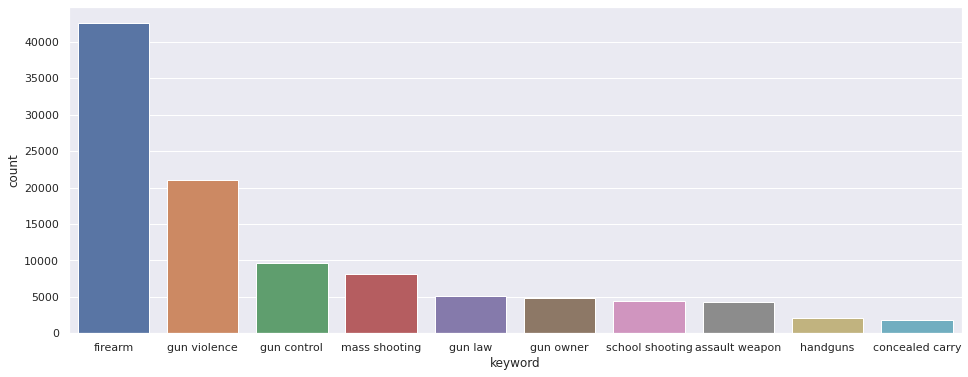

In [13]:
plt.figure(figsize=(16, 6))
sns.set_theme(style="darkgrid")
sns.countplot(quotes['keyword'], order=quotes['keyword'].value_counts().iloc[:10].index)

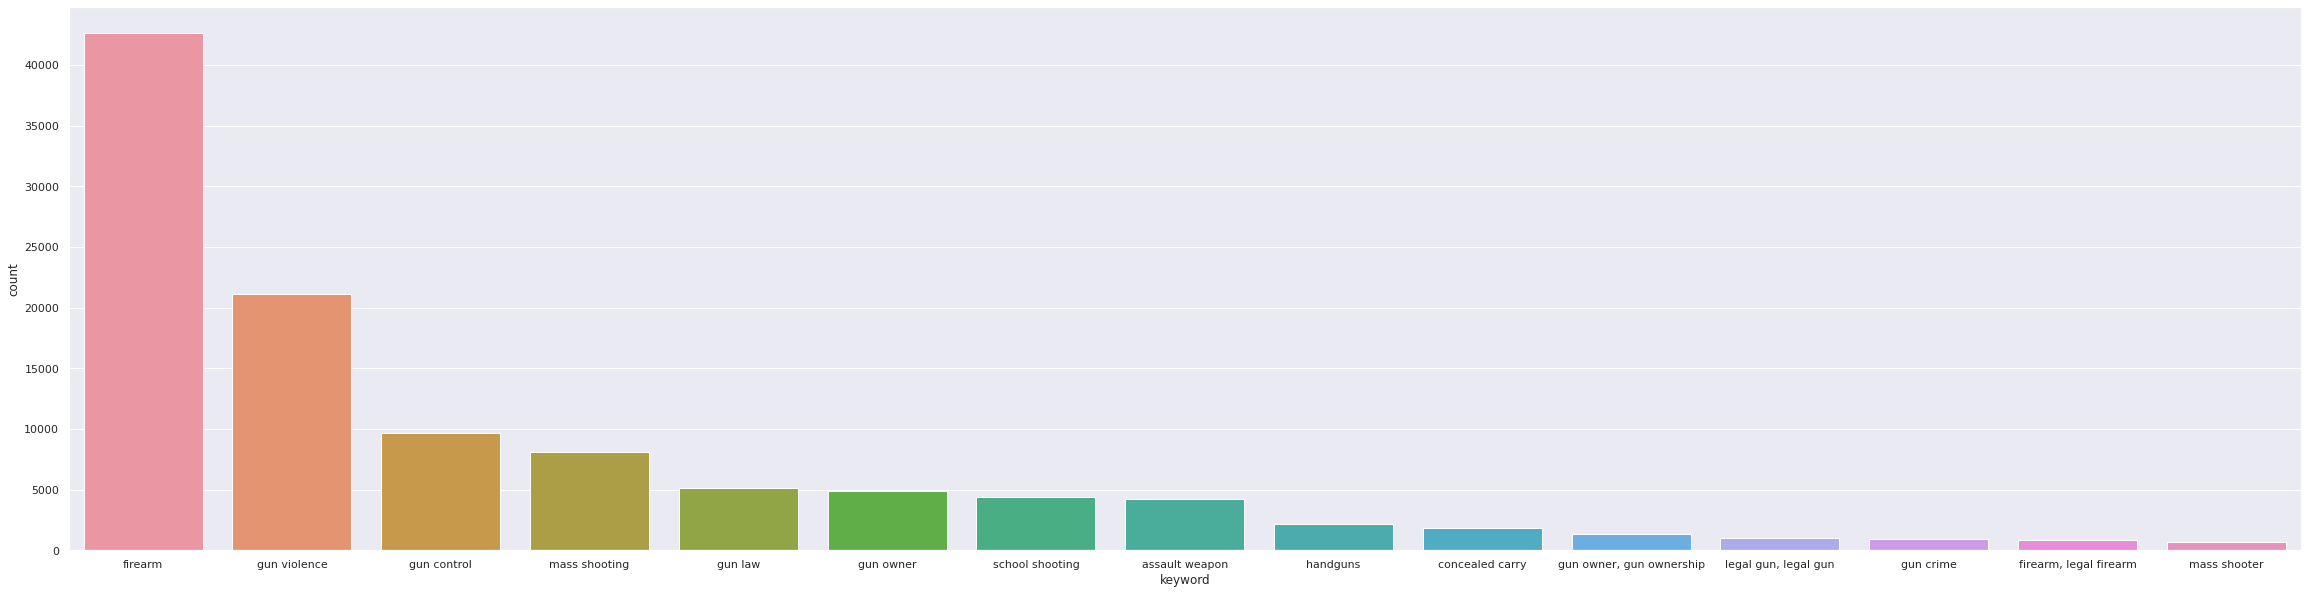

In [14]:
plt.figure(figsize=(40, 10))
sns.set_theme(style="darkgrid")
sns.countplot(quotes['keyword'], order=quotes['keyword'].value_counts().iloc[:15].index)

*For this nice wordclous create maybe custom stopwords from document and redo it with better polishing nlp pipeline*


In [ ]:

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lm = WordNetLemmatizer()
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [ ]:
corpus = text_transformation(quotes['quotation'])
#took 9 mins to run

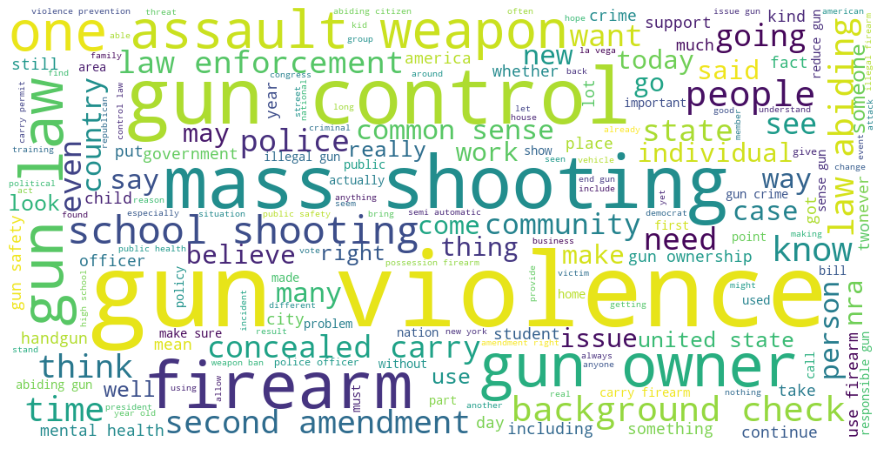

In [ ]:
from wordcloud import WordCloud
plt.rcParams['figure.figsize'] = 20,8
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)
plt.grid('False')
plt.xticks([])
plt.yticks([])
plt.show()
#takes a bit

Initialize the Spacy analyzer in English

In [32]:
nlp = spacy.load('en_core_web_sm') #enlgish package optimized for efficiency not accuracy, , disable=['tagger', 'parser', 'ner']
#try removing those to check speed

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [ ]:
#see if it makes sense to use tools more for social media (recheck sentence length) and see if bimodal distribution

In [ ]:
#consider filtering even more the quotes
'''def cleaner(df):
    "Extract relevant text from DataFrame using a regex"
    # Regex pattern for only alphanumeric, hyphenated text with 3 or more chars
    pattern = re.compile(r"[A-Za-z0-9\-]{3,50}")
    df['clean'] = df['content'].str.findall(pattern).str.join(' ')
    if limit > 0:
        return df.iloc[:limit, :].copy()
    else:
        return df

df_preproc = cleaner(df)
df_preproc.head(3)'''

#maybe just alpha numeric, punctuactions and hyphenated text with 3 or more chars

In [33]:
quotes[quotes['quotation'].str.contains('\n',regex=False)] #no apparent /n (new line), no need to filter those out
#quotes['quotation'] = quotes['quotation'].replace(r'\s+|\\n', ' ', regex=True) not needed

,speaker,qids,date,quotation,keyword


Quickly check if it's worth polishing for some weird extra alpha numerical characters, (vader given that it was built on social media data should be able to handle it but ultimately if we wanna use also other sentiment analysis tool might be better to clean it)

There might be some weird residues from the origianl html dump

In [15]:
quotes[quotes['quotation'].str.contains('WTF',regex=False)]

,speaker,qids,date,quotation,keyword
1187,Geraldo Rivera,[Q1368995],2015-12-03 15:16:23,Mass shooting in San Bernadino (sic) Californi...,mass shooting
5997,Geraldo Rivera,[Q1368995],2015-12-03 17:50:45,Mass shooting in San Bernadino California at a...,mass shooting
949,None,[],2018-12-05 10:28:00,Why oh why gen a gun? How disrespectful to any...,gun violence
6390,Fred Guttenberg,[Q50380052],2018-05-02 12:43:53,Looks like the Sun Sentinel editor on this pag...,gun violence
16406,Rainn Wilson,[Q349548],2019-08-04 22:35:58,"I can't even imagine. America, WTF is wrong wi...",mass shooting
21899,Tommy Lee,"[Q19854281, Q21059978, Q331748, Q7819617, Q781...",2019-08-05 15:19:29,dude!! @realDonaldTrump one minute you blame m...,mass shooting


In [16]:
quotes[quotes['quotation'].str.contains('@',regex=False)] #326 matches

,speaker,qids,date,quotation,keyword
4645,President Obama,[Q76],2015-12-24 14:13:14,I'm proud of the @NBA for taking a stand again...,gun violence
7243,None,[],2015-06-18 12:41:54,Congratulations to the @NRA on another success...,mass shooting
7301,Chuck Schumer,[Q380900],2015-10-26 08:23:40,Please join me and @SenSchumer in ending gun v...,gun violence
7611,Piers Morgan,[Q557758],2015-12-03 09:58:00,Completely agree with @PiersMorgan on GMB rega...,gun control
8554,Piers Morgan,[Q557758],2015-11-05 15:27:56,"Actually @kingsthings, I made my CNN show all ...",gun control
...,...,...,...,...,...
25568,Jake Tapper,[Q6125032],2019-11-14 20:07:02,the shooter in the Saugus high school shooting...,school shooting
25657,Ann Coulter,[Q266611],2019-08-07 21:35:04,QUIZ: Does @realDonaldTrump know less about gu...,gun law
25713,John Cranley,"[Q51547682, Q6227508]",2019-09-19 20:25:50,Thank you to @GovMikeDeWine for spending a sig...,gun violence
25841,David Begnaud,[Q49700963],2019-01-11 13:16:47,One of the few openly gay singers in Puerto Ri...,gun violence


In [17]:
quotes[quotes['quotation'].str.contains('&',regex=False)]

,speaker,qids,date,quotation,keyword
54,None,[],2015-12-24 11:01:33,war on yours & my concealed carry permit,concealed carry
242,Darren Jones,"[Q30174665, Q5224996, Q57912951]",2015-07-14 17:47:06,regain our Voice. To exercise our right to pro...,gun owner
296,Wade Noonan,[Q7959098],2015-08-20 14:00:00,theft of a & shy; firearm,firearm
524,Julie Golob,[Q6308201],2015-02-02 13:10:41,Thirty years ago I fell in love with the shoot...,"gun owner, firearm, gun ownership"
710,None,[],2015-10-15 14:42:25,If the US had strict gun control laws & some p...,gun control
...,...,...,...,...,...
25240,Tsai Ing-wen,[Q233984],2019-03-15 12:35:45,I'm utterly saddened by the mass shooting in C...,mass shooting
25409,Ted Cruz,[Q2036942],2019-09-02 00:00:00,It is of course not the right to a modern-day ...,firearm
25671,Eric Swalwell,[Q3466996],2019-07-09 05:24:05,"I want thank my supporters & friends, my staff...",gun violence
25714,Reese Witherspoon,[Q44063],2019-09-15 15:24:02,This is the 18th in 45 days of 2018. Students ...,gun violence


In [42]:
ind = quotes['quotation'].str.contains('â',regex=False)
print(ind)

0        False
1        False
2        False
3        False
4        False
         ...  
26262    False
26263    False
26264    False
26265    False
26266    False
Name: quotation, Length: 119535, dtype: bool


In [50]:
quotes[quotes['quotation'].str.contains('â',regex=False)] #there seems to be very few strange characters, still due to old html dumps

,speaker,qids,date,quotation,keyword
2098,None,[],2015-04-15 20:48:23,In reaffirming the greatness of our nation we ...,"legal gun, legal gun"
14181,President Obama,[Q76],2015-06-20 23:44:21,"But letâ € ™ s be clear: at some point, we as ...",gun violence
1680,None,[],2017-10-13 00:37:18,FILE - This undated file photo provided by Eri...,mass shooting
2062,Greg O'Connor,"[Q28600237, Q5606067]",2017-02-18 20:55:17,My position is that arming is inevitable unles...,"firearm, legal gun, legal gun"
9116,None,[],2017-06-20 16:38:50,"According to their rhetoric, this is everythin...",firearm
12524,Matt Lauer,[Q1100609],2017-07-24 13:18:57,"No, I'm not suggesting that, Matt. I'm telling...","gun owner, gun ownership"
12630,DC Young Fly,[Q24895237],2017-10-03 00:40:46,"Last night in Las Vegas, a horrible tragedy to...",mass shooting
15114,None,[],2017-12-18 19:16:25,The main reason I hated ALICE Drill days was t...,mass shooting
15297,Tim Fischer,"[Q1367112, Q7803493, Q7803494]",2017-10-06 21:40:56,"Since 1996, since Port Arthur, since the gun l...","mass shooting, gun law"
15707,President Trump,[Q22686],2017-10-05 16:04:14,Weâ   ll be talking about gun laws as time g...,gun law


In [51]:
quotes['quotation'] = quotes['quotation'].str.replace('â ','\'')

In [52]:
quotes[ind] #fix it better, at the source before removing unescaped HTML characters

,speaker,qids,date,quotation,keyword
2098,None,[],2015-04-15 20:48:23,In reaffirming the greatness of our nation we ...,"legal gun, legal gun"
14181,President Obama,[Q76],2015-06-20 23:44:21,"But let'€ ™ s be clear: at some point, we as a...",gun violence
1680,None,[],2017-10-13 00:37:18,FILE - This undated file photo provided by Eri...,mass shooting
2062,Greg O'Connor,"[Q28600237, Q5606067]",2017-02-18 20:55:17,My position is that arming is inevitable unles...,"firearm, legal gun, legal gun"
9116,None,[],2017-06-20 16:38:50,"According to their rhetoric, this is everythin...",firearm
12524,Matt Lauer,[Q1100609],2017-07-24 13:18:57,"No, I'm not suggesting that, Matt. I'm telling...","gun owner, gun ownership"
12630,DC Young Fly,[Q24895237],2017-10-03 00:40:46,"Last night in Las Vegas, a horrible tragedy to...",mass shooting
15114,None,[],2017-12-18 19:16:25,The main reason I hated ALICE Drill days was t...,mass shooting
15297,Tim Fischer,"[Q1367112, Q7803493, Q7803494]",2017-10-06 21:40:56,"Since 1996, since Port Arthur, since the gun l...","mass shooting, gun law"
15707,President Trump,[Q22686],2017-10-05 16:04:14,We'  ll be talking about gun laws as time go...,gun law


Then maybe also check for the issue found on the quotebank issues, with the fix if not already done 8before doing the chunking)

In [53]:
quotes[quotes['quotation'].str.contains('nbsp',regex=False)] #is the weird character encoded

,speaker,qids,date,quotation,keyword
16509,None,[],2017-10-03 02:37:56,It always seems like the worst displays of hum...,gun violence


In [25]:
quotes[quotes['quotation'].str.contains('¢',regex=False)] #no occurences

,speaker,qids,date,quotation,keyword


In [27]:
quotes[quotes['quotation'].str.contains('Å',regex=False)]

,speaker,qids,date,quotation,keyword


In [28]:
quotes[quotes['quotation'].str.contains('Æ',regex=False)]

,speaker,qids,date,quotation,keyword


In [29]:
quotes[quotes['quotation'].str.contains('¥',regex=False)]

,speaker,qids,date,quotation,keyword


In [30]:
quotes[quotes['quotation'].str.contains('€',regex=False)]

,speaker,qids,date,quotation,keyword
2098,None,[],2015-04-15 20:48:23,In reaffirming the greatness of our nation we ...,"legal gun, legal gun"
6285,None,[],2015-02-12 11:18:38,"To date, this investigation has led to the sei...",firearm
14181,President Obama,[Q76],2015-06-20 23:44:21,"But letâ € ™ s be clear: at some point, we as ...",gun violence
18503,Mark Dennehy,[Q26251679],2015-01-21 20:58:23,"I don't think it's right that since 2009, any ...",firearm
5624,Michael Corcoran,[Q4839671],2016-09-30 10:51:29,"The danger to life of a guard, whether that be...",gun crime
7749,Daisy Ridley,[Q16738674],2016-08-04 00:00:00,Thinking about how lucky I am like... Serious ...,gun violence
11150,Daisy Ridley,[Q16738674],2016-08-04 13:12:57,sat in the audience yesterday tears were strea...,gun violence
11848,Daisy Ridley,[Q16738674],2016-08-04 10:01:00,Thinking about how lucky I am like... Serious ...,gun violence
2062,Greg O'Connor,"[Q28600237, Q5606067]",2017-02-18 20:55:17,My position is that arming is inevitable unles...,"firearm, legal gun, legal gun"
9116,None,[],2017-06-20 16:38:50,"According to their rhetoric, this is everythin...",firearm


## decided to use vader bc designed for social media where sentiment very polarized. Especially concerning this context we think it makes more sense. You can see that some typical characters only present in social media are in the dataset.


Also unlike with some supervised methods of NLP, preprocessing necessities such as tokenisation and stemming/lemmatisation are not required. You can pretty much plug in any body of text and it will determine the sentiment.
VADER is even smart enough to understand the valence of non-conventional text, including emojis (i.e. :-( ), capitalisation (i.e. sad vs SAD) and extended punctuation (i.e. ? vs ???). This is what makes the module so good at analysing social media text. Additionally, VADER removes stop words automatically so there is no need to do so yourself.

In [63]:
analyzer = SentimentIntensityAnalyzer()

In [64]:
def sent_an(text):
  doc = nlp(text)
  return analyzer.polarity_scores(doc.text)

In [ ]:
def count

In [65]:
new_df = quotes.copy(deep=True)
new_df['scores'] = new_df['quotation'].apply(sent_an)
#new_df['compound']  = new_df['scores'].apply(

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

In [66]:
new_df['scores']

0        {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1        {'neg': 0.213, 'neu': 0.733, 'pos': 0.054, 'co...
2        {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3        {'neg': 0.561, 'neu': 0.344, 'pos': 0.095, 'co...
4        {'neg': 0.059, 'neu': 0.85, 'pos': 0.091, 'com...
                               ...                        
26262    {'neg': 0.397, 'neu': 0.48, 'pos': 0.122, 'com...
26263    {'neg': 0.088, 'neu': 0.853, 'pos': 0.06, 'com...
26264    {'neg': 0.636, 'neu': 0.14, 'pos': 0.224, 'com...
26265    {'neg': 0.054, 'neu': 0.721, 'pos': 0.225, 'co...
26266    {'neg': 0.115, 'neu': 0.885, 'pos': 0.0, 'comp...
Name: scores, Length: 119535, dtype: object

In [67]:
new_df['compound'] = new_df['scores'].apply(lambda score_dict: score_dict['compound'])


In [75]:
new_df.drop(columns=['sentiment_type','sent_type'])

,speaker,qids,date,quotation,keyword,scores,compound
0,None,[],2015-12-07 01:54:26,cannot identify every would-be mass shooter.,mass shooter,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,President Obama,[Q76],2015-07-23 10:46:00,If you look at the number killed by gun violen...,gun violence,"{'neg': 0.213, 'neu': 0.733, 'pos': 0.054, 'co...",-0.8271
2,Jim Wallace,"[Q16751191, Q333807, Q6145053, Q6198737, Q6198...",2015-04-21 10:05:54,It's $100 for the Firearm Identification Card ...,firearm,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
3,Donald Trump,"[Q22686, Q27947481]",2015-09-19 05:27:02,"scary sounding phrases like `assault weapons,'...",assault weapon,"{'neg': 0.561, 'neu': 0.344, 'pos': 0.095, 'co...",-0.9042
4,President Obama,[Q76],2015-12-02 22:42:13,It's still an active situation. FBI is on the ...,"mass shooting, firearm","{'neg': 0.059, 'neu': 0.85, 'pos': 0.091, 'com...",0.8902
...,...,...,...,...,...,...,...
26262,Eric Swalwell,[Q3466996],2019-02-04 20:48:28,After 6 yrs of working in Congress to end gun ...,gun violence,"{'neg': 0.397, 'neu': 0.48, 'pos': 0.122, 'com...",-0.7430
26263,Beto O'Rourke,[Q4014532],2019-09-18 11:00:55,Credit cards have enabled many of America's ma...,mass shooting,"{'neg': 0.088, 'neu': 0.853, 'pos': 0.06, 'com...",-0.2960
26264,None,[],2019-11-24 14:15:58,"Giffords: Courage to Fight Gun Violence,",gun violence,"{'neg': 0.636, 'neu': 0.14, 'pos': 0.224, 'com...",-0.7096
26265,None,[],2019-10-21 17:43:34,If homegrown individual candidates with compel...,gun control,"{'neg': 0.054, 'neu': 0.721, 'pos': 0.225, 'co...",0.7650


In [76]:
new_df['sent_type']=''
new_df.loc[new_df.compound>=0.05,'sent_type']='POS'
new_df.loc[(new_df.compound<0.05) & (new_df.compound>-0.05),'sent_type']='NEU'
new_df.loc[new_df.compound<=-0.05,'sent_type']='NEG'

Text(0, 0.5, 'Number of quotes')

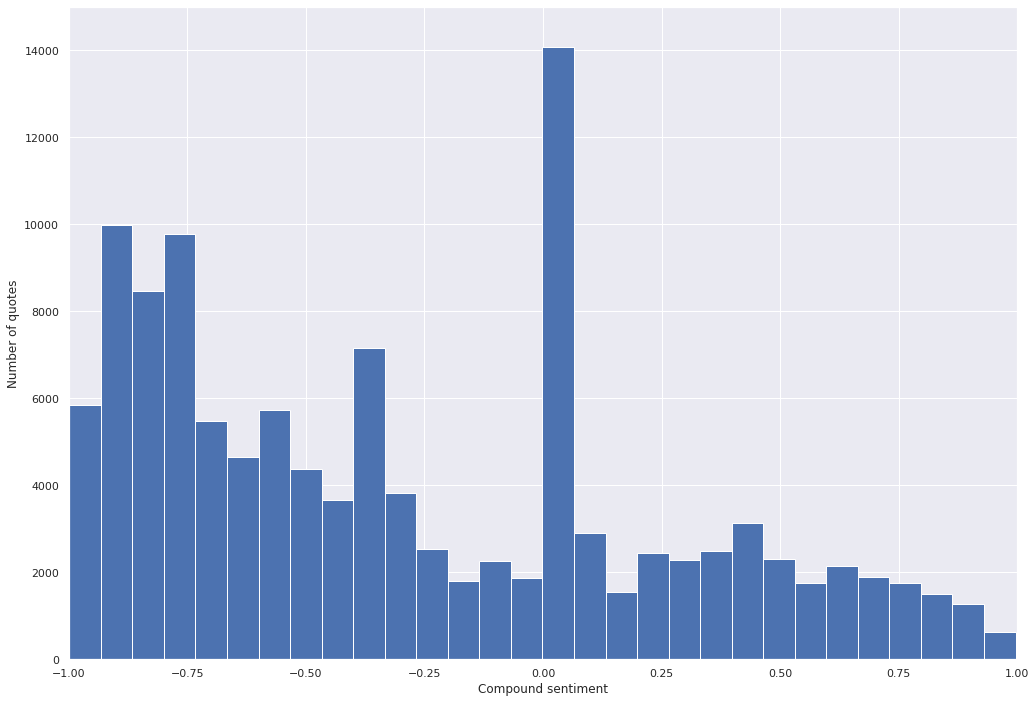

In [112]:
plt.figure(figsize=(17, 12))
new_df.compound.hist(bins=30)
plt.xlim([-1,1])
plt.ylim([0,15000])
plt.xlabel('Compound sentiment')
plt.ylabel('Number of quotes')

Text(0, 0.5, 'Number of quotes')

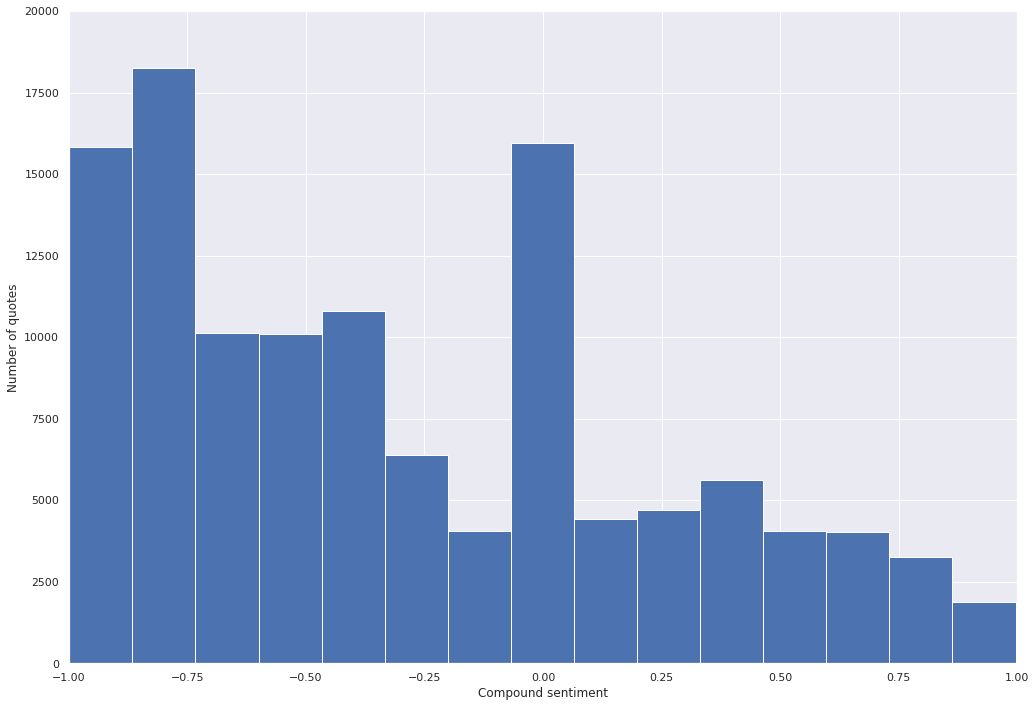

In [114]:
plt.figure(figsize=(17, 12))
new_df.compound.hist(bins=15)
plt.xlim([-1,1])
plt.ylim([0,20000])
plt.xlabel('Compound sentiment')
plt.ylabel('Number of quotes')

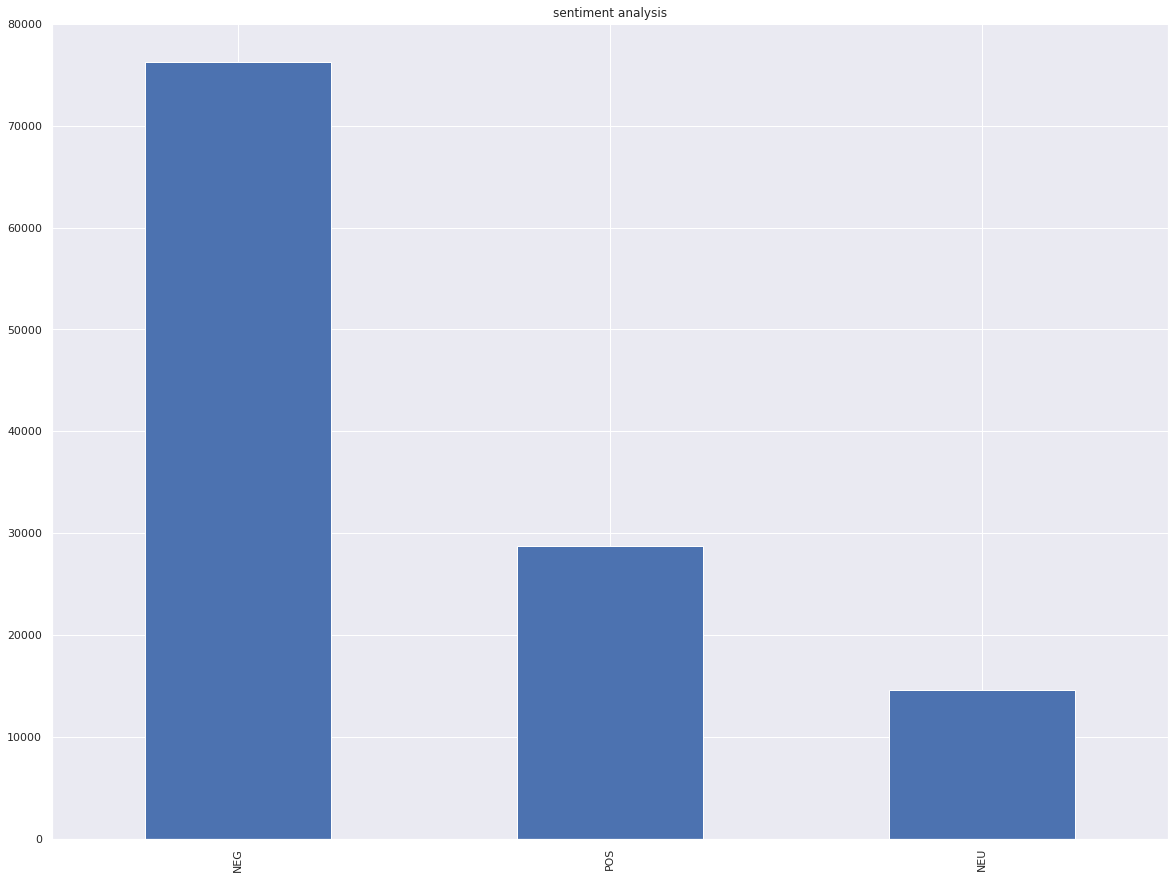

In [82]:
plt.figure(figsize=(20, 15))
new_df.sent_type.value_counts().plot(kind='bar',title="sentiment analysis")

now redo the graphs at the end

In [ ]:
plt.hist(total_sent,bins = 15)
plt.xlim([-1,1])
plt.ylim([0,100000])
plt.xlabel('Compound sentiment')
plt.ylabel('Number of sentences')'''

In [96]:
g = new_df.query("compound > 0.5")

In [97]:
for i in range(20):
  print(g.iloc[i,3])
  print('/n')

It's still an active situation. FBI is on the ground offering assistance to local officials as they need it. It does appear that there are going to be some casualties. And, obviously our hearts go out to the victims and the families. The one thing we do know is that we have a pattern now of mass shootings in this country that has no parallel anywhere else in the world. And there are some steps we could take not to eliminate every one of these mass shootings, but to improve the odds that they don't happen as frequently: common-sense gun safety laws, stronger background checks. And for those who are concerned about terrorism, some may be aware of the fact that we have a no-fly list where people can't get on planes, but those same people who we don't allow to fly could go into a store right now in the United States and buy a firearm and there's nothing that we can do to stop them. That's a law that needs to be changed. And so my hope is that we're able to contain this particular shooting,

In [ ]:
'''print('Number of positive sentences:', new_df.query("sent_type == POS").count())
print('Number of negative sentences:', np.abs(new_df.query("compound <= -0.05")['compound'].sum()))
print('Number of neutral sentences:', new_df.query("compound < 0.05 & compound > -0.05")['compound'].sum())'''

see if filtering for fewer words makes sense, also try just on known speakers.

In [100]:
words = [token.text for token in doc]

In [58]:
len(words)

38

In [41]:
words = [token.text for token in doc]
word_freq = Counter(words)
common_words = word_freq.most_common()
print(common_words)

[('the', 4), ('of', 3), ('on', 2), ('campus', 2), ('to', 2), ('The', 1), ('recent', 1), ('shooting', 1), ('FSU', 1), ('and', 1), ('series', 1), ('rapes', 1), ('at', 1), ('University', 1), ('Florida', 1), ('taught', 1), ('us', 1), ('that', 1), ('we', 1), ('need', 1), ('restore', 1), ('rights', 1), ('licensed', 1), ('adults', 1), ('carry', 1), ('concealed', 1), ('firearms', 1), ('for', 1), ('protection', 1), (',', 1)]


In [59]:
print(doc.text)

The recent shooting on the FSU campus and the series of rapes at the University of Florida taught us that we need to restore the rights of licensed adults to carry concealed firearms on campus for protection,


# just quickly try to run sentment analysis on the all the sentences to get an idea of the distribution, as you see there are way more sentences than quotes.

Just to explore what's up.

In [ ]:
'''#quickly try what done in the homework, dumb loop looking at all the sentences (might be more than one sentence in each quote)
positive_sent = []
negative_sent = []
total_sent = []
for i in quotes['quotation'].tolist():
    doc = nlp(i)
    for sent in doc.sents:
      positive_sent.append(analyzer.polarity_scores(sent.text)['pos'])
      negative_sent.append(analyzer.polarity_scores(sent.text)['neg'])
      total_sent.append(analyzer.polarity_scores(sent.text)['compound'])'''
                        
#taking more 29 mins

In [ ]:
print(nlp.pipeline)

[('tagger', <spacy.pipeline.pipes.Tagger object at 0x7f5c4e689650>), ('parser', <spacy.pipeline.pipes.DependencyParser object at 0x7f5c3d3f0600>), ('ner', <spacy.pipeline.pipes.EntityRecognizer object at 0x7f5c3d3f0910>)]


Quickly analyze with vader sent an, with dumb nlp preprocessing pipeline before

In [ ]:
'''#clean any blank spaces withing the quotes, use a better polished pipeline for this part
blanks = []  # start with an empty list
new_df = quotes(['speaker'],['date'],['quotation'])
for i,rv in new_df.itertuples():  
    if type(rv)==str:            
        if rv.isspace():        
            blanks.append(i)     

new_df.drop(blanks, inplace=True)'''

In [ ]:
'''new_df = quotes.copy(deep=True)
new_df['scores'] = new_df['quotation'].apply(lambda quotation: analyzer.polarity_scores(quotation))
new_df['compound']  = new_df['scores'].apply(lambda score_dict: score_dict['compound'])


new_df.head()'''

,speaker,qids,date,quotation,keyword,scores
0,None,[],2015-12-04 00:31:23,if such firearm purchase would increase such p...,firearm,"{'neg': 0.196, 'neu': 0.638, 'pos': 0.166, 'co..."
1,None,[],2015-02-19 05:41:58,"I'm all for that, I'm a gun advocate, the only...",gun advocate,"{'neg': 0.289, 'neu': 0.711, 'pos': 0.0, 'comp..."
2,None,[],2015-02-25 13:13:00,While the GOP-dominated state Legislature has ...,firearm,"{'neg': 0.055, 'neu': 0.818, 'pos': 0.127, 'co..."
3,Andrew Cuomo,[Q11673],2015-09-26 18:14:00,It is not enough for New York State to pass a ...,gun law,"{'neg': 0.051, 'neu': 0.949, 'pos': 0.0, 'comp..."
4,Robin Kelly,[Q3437091],2015-10-30 15:20:29,America has suffered the tragedies of mass sho...,"mass shooting, firearm","{'neg': 0.421, 'neu': 0.579, 'pos': 0.0, 'comp..."


### Idea create the labels with vader sentiment analysis and then perform classification with some model for sentiment analysis

#### Most of the sentences are quite neutral in sentiment. This is not the case when working with data from other sources (e.g., in social media opinions are strong and polarized (bimodal distribution)). Not sure what to make out of this related to our case.

##gunshot dataset part

In [115]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats

In [116]:
DATA_FOLDER = '/content/drive/MyDrive/datasets_ADA/gunshot/'

MASS_SHOOTINGS_15 = DATA_FOLDER+"massshootings15.csv"
MASS_SHOOTINGS_16 = DATA_FOLDER+"massshootings16.csv"
MASS_SHOOTINGS_17 = DATA_FOLDER+"massshootings17.csv"
MASS_SHOOTINGS_18 = DATA_FOLDER+"massshootings18.csv"
MASS_SHOOTINGS_19 = DATA_FOLDER+"massshootings19.csv"
ACCIDENTS = DATA_FOLDER+"accidents.csv"

In [117]:
mass_shootings_15 = pd.read_csv(MASS_SHOOTINGS_15)
mass_shootings_16 = pd.read_csv(MASS_SHOOTINGS_16)
mass_shootings_17 = pd.read_csv(MASS_SHOOTINGS_17)
mass_shootings_18 = pd.read_csv(MASS_SHOOTINGS_18)
mass_shootings_19 = pd.read_csv(MASS_SHOOTINGS_19)
accidents = pd.read_csv(ACCIDENTS)

In [118]:
mass_shootings=pd.concat([mass_shootings_15, mass_shootings_16, mass_shootings_17, mass_shootings_18,
                          mass_shootings_19], ignore_index=True)

In [119]:
mass_shootings = mass_shootings.drop(columns=['State', 'City Or County', 'Address', 'Operations'])
mass_shootings['Category']='Mass Shooting'
mass_shootings['Incident Date'] = pd.to_datetime(mass_shootings['Incident Date'])
accidents = accidents.drop(columns=['State', 'City Or County', 'Address', 'Operations'])
accidents = accidents[~accidents['Incident Date'].str.contains("2021")]
accidents = accidents[~accidents['Incident Date'].str.contains("2020")]
accidents['Category']='Accident'
accidents['Incident Date'] = pd.to_datetime(accidents['Incident Date'])

In [120]:
mass_shootings.sort_values('# Killed', ascending=False).head()

,Incident ID,Incident Date,# Killed,# Injured,Category
788,946496,2017-10-01,59,441,Mass Shooting
581,577157,2016-06-12,50,53,Mass Shooting
754,980577,2017-11-05,27,20,Mass Shooting
1574,1466705,2019-08-03,23,23,Mass Shooting
1372,1049217,2018-02-14,17,17,Mass Shooting


In [121]:
accidents.sort_values('# Killed', ascending=False).head()

,Incident ID,Incident Date,# Killed,# Injured,Category
1058,1564937,2019-12-05,4,1,Accident
1400,1323697,2019-02-09,2,0,Accident
1985,926038,2017-09-02,2,0,Accident
1825,1031159,2018-01-19,2,0,Accident
1445,1289271,2018-12-31,2,0,Accident


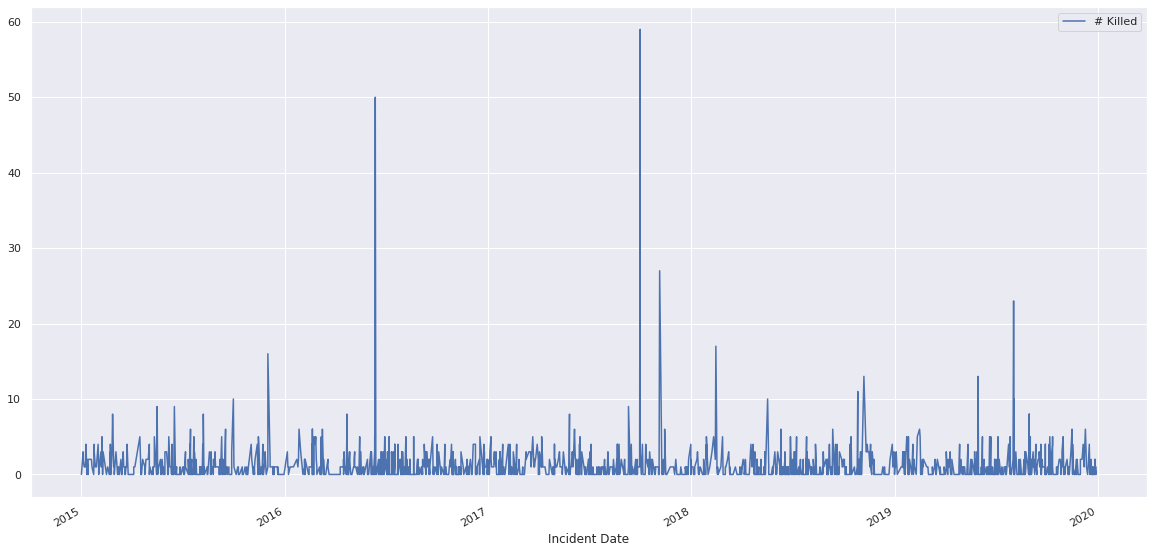

In [122]:
mass_shootings.plot(x='Incident Date', y='# Killed', figsize=(20,10));

In [123]:
new_df['date'] = new_df.date.dt.date #new df is the quotes dataset, just created a new one to not mess with th old one

In [130]:
gg = mass_shootings.groupby('Incident Date').sum()['# Killed'].to_frame(name = 'N Killed').reset_index()

In [125]:
pp = new_df.groupby('date').mean().compound.to_frame(name = 'Avg compound score par day').reset_index()

In [133]:
pp

,date,Avg compound score par day
0,2015-01-01,-0.194931
1,2015-01-02,-0.402017
2,2015-01-03,-0.038957
3,2015-01-04,0.084733
4,2015-01-05,-0.267843
...,...,...
1739,2019-12-27,-0.198142
1740,2019-12-28,-0.225592
1741,2019-12-29,-0.389812
1742,2019-12-30,-0.294227


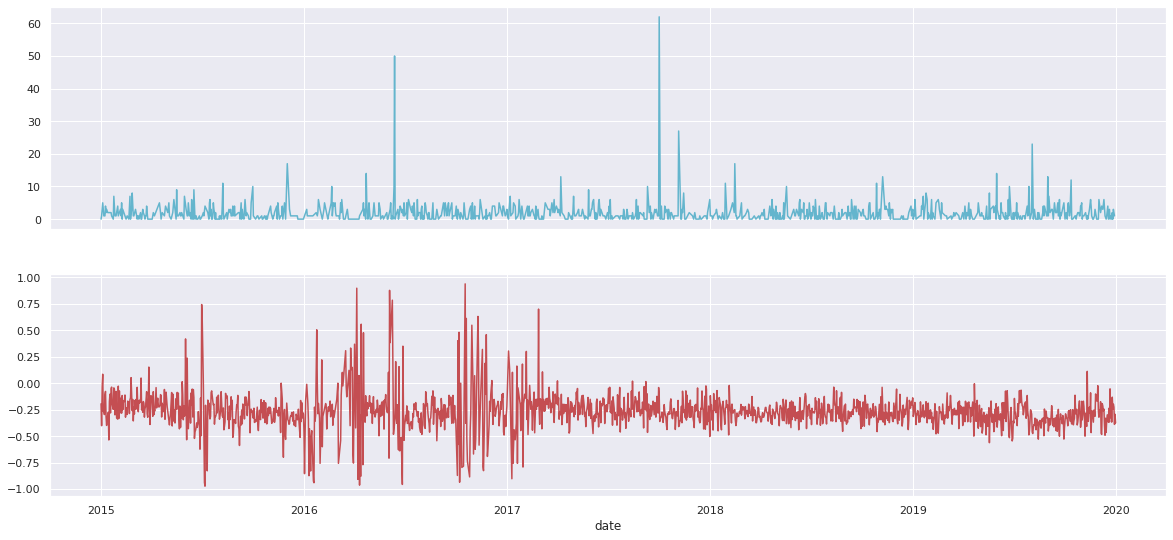

In [149]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(40, 15)
gg.plot(x='Incident Date', y='N Killed', figsize=(20,10), ax=axs[0], grid=True, color='c', legend=False);
pp.plot(x='date', y='Avg compound score par day', figsize=(20,10), ax=axs[1], grid=True, color='r', legend=False)

In [143]:
new_df['date'] = pd.to_datetime(new_df['date'])

In [144]:
new_df.groupby(pd.Grouper(key='date', axis=0, freq='5D', sort=True))

In [146]:
ppp = new_df.groupby(pd.Grouper(key='date', axis=0, freq='5D', sort=True)).mean().compound.to_frame(name = 'Avg compound score par day').reset_index()

In [147]:
ppp

,date,Avg compound score par day
0,2015-01-01,-0.232570
1,2015-01-06,-0.194226
2,2015-01-11,-0.374308
3,2015-01-16,-0.120696
4,2015-01-21,-0.188879
...,...,...
361,2019-12-11,-0.408523
362,2019-12-16,-0.312460
363,2019-12-21,-0.172216
364,2019-12-26,-0.271008


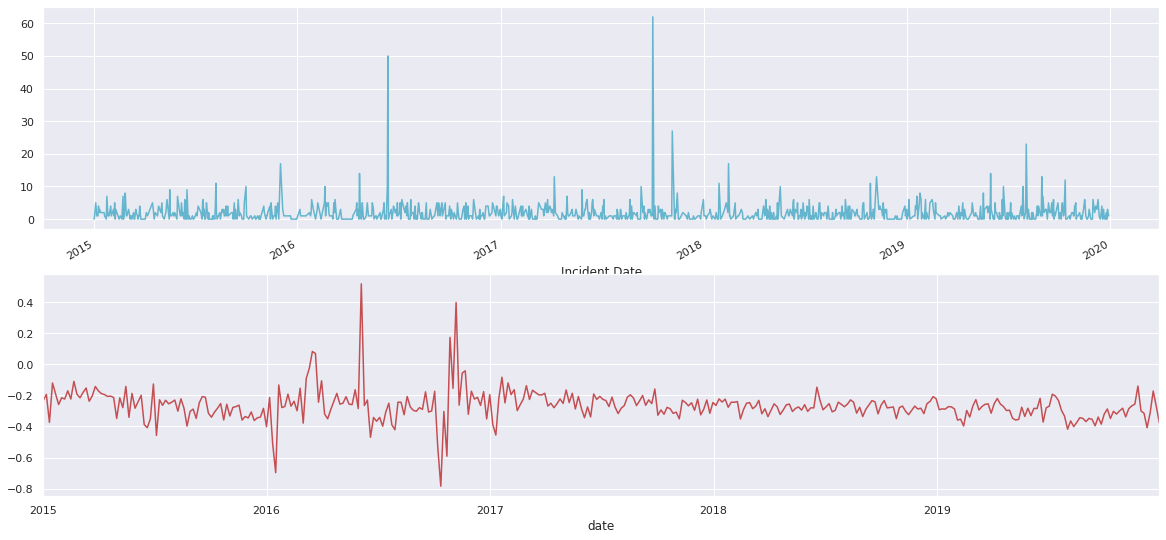

In [151]:
fig, axs = plt.subplots(2, 1)
fig.set_size_inches(40, 15)
gg.plot(x='Incident Date', y='N Killed', figsize=(20,10), ax=axs[0], grid=True, color='c', legend=False);
ppp.plot(x='date', y='Avg compound score par day', figsize=(20,10), ax=axs[1], grid=True, color='r', legend=False)

prob a lot of oscillations intra day so maybe try to do rolling avg or smth

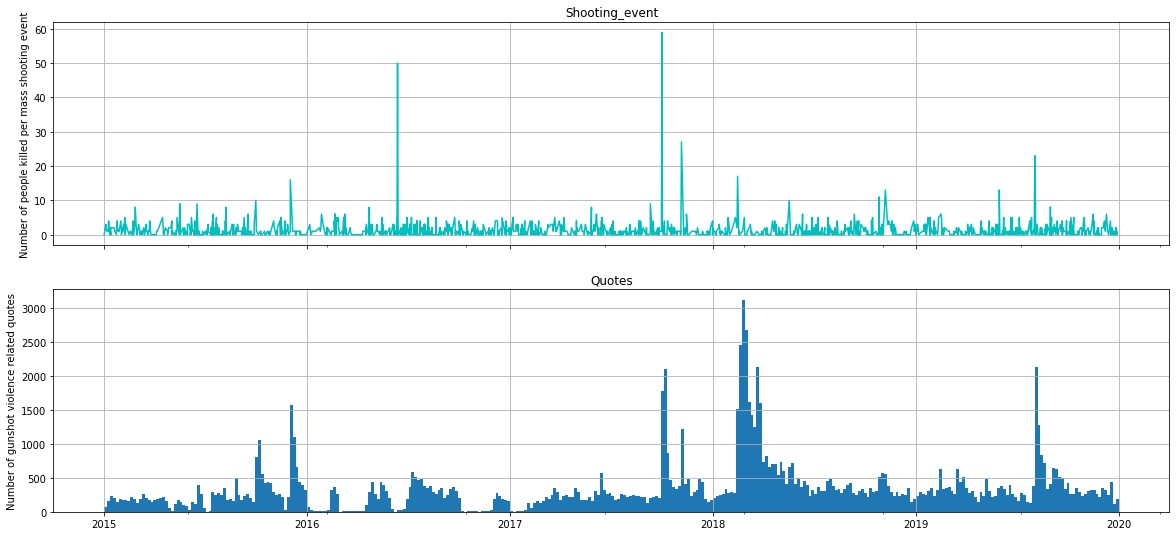

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(20, 10)
mass_shootings.plot(x='Incident Date', y='# Killed', figsize=(20,10), ax=axs[0], grid=True, color='c', legend=False);
quotes['date'].hist(figsize=(20,10), bins = 350, ax=axs[1]);
axs[0].set_title('Shooting_event');
axs[0].set_ylabel('Number of people killed per mass shooting event');
axs[1].set_title('Quotes');
axs[1].set_ylabel('Number of gunshot violence related quotes');

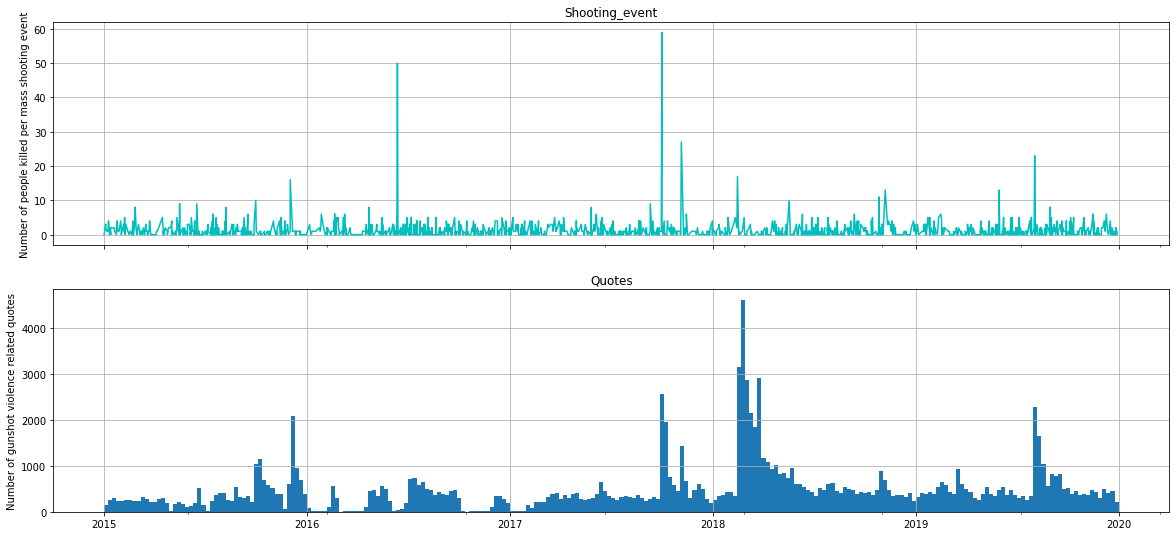

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(20, 10)
mass_shootings.plot(x='Incident Date', y='# Killed', figsize=(20,10), ax=axs[0], grid=True, color='c', legend=False);
quotes['date'].hist(figsize=(20,10), bins = 250, ax=axs[1]);
axs[0].set_title('Shooting_event');
axs[0].set_ylabel('Number of people killed per mass shooting event');
axs[1].set_title('Quotes');
axs[1].set_ylabel('Number of gunshot violence related quotes');

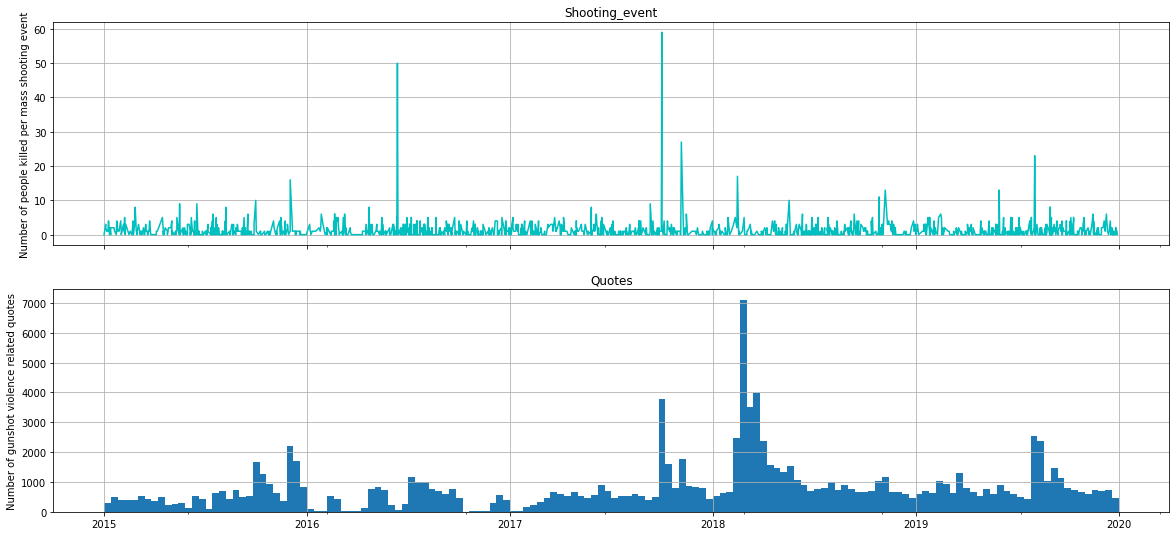

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(20, 10)
mass_shootings.plot(x='Incident Date', y='# Killed', figsize=(20,10), ax=axs[0], grid=True, color='c', legend=False);
quotes['date'].hist(figsize=(20,10), bins = 150, ax=axs[1]);
axs[0].set_title('Shooting_event');
axs[0].set_ylabel('Number of people killed per mass shooting event');
axs[1].set_title('Quotes');
axs[1].set_ylabel('Number of gunshot violence related quotes');

From a visual inspection there seems to be some rough correlation (with those more or less corresponding peaks, exception raised for the second highest peak in the shooting event dataset) between the number of people killed per shooting event and a relatively high number of gunshot violence related quotes in similar dates.


Finished